In [2]:
import os
import pandas as pd
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import warnings


df = pd.read_excel("./data/spy_data.xlsx", sheet_name = 'total returns')
df = df.set_index('date')
df['Excess_SPY'] = df['SPY'] - df['^IRX']
df


,SPY,^IRX,Excess_SPY
date,,,
1994-01-04,0.004035,0.000122,0.003913
1994-01-05,0.002009,0.000122,0.001888
1994-01-06,0.000000,0.000121,-0.000121
1994-01-07,0.006016,0.000119,0.005897
1994-01-10,0.011960,0.000119,0.011841
...,...,...,...
2024-07-29,0.000588,0.000204,0.000384
2024-07-30,-0.005066,0.000204,-0.005270
2024-07-31,0.016255,0.000204,0.016051


## Historic VaR

5% VaR backtest: 5.63%


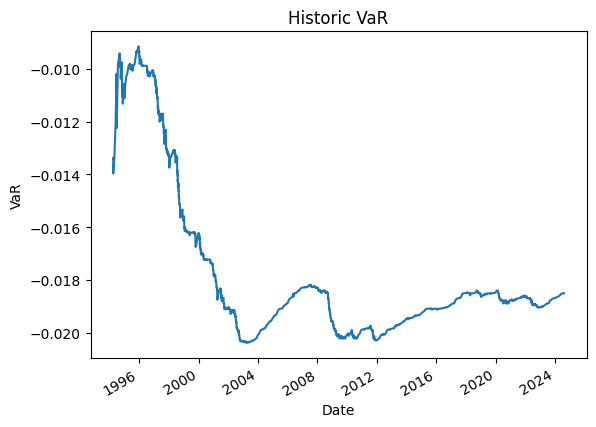

In [13]:
rets = df['Excess_SPY']
returns = rets.shift()

# Start at t = 61 

min_periods = 60
var_quantile = 0.05

historic_VaR = returns.expanding(min_periods = min_periods).quantile(var_quantile)
historic_VaR.plot(title = 'Historic VaR', ylabel = 'VaR', xlabel = 'Date')

exceed = sum(rets < historic_VaR)/len(historic_VaR.dropna())
print('5% VaR backtest: {:,.2%}'.format(exceed))

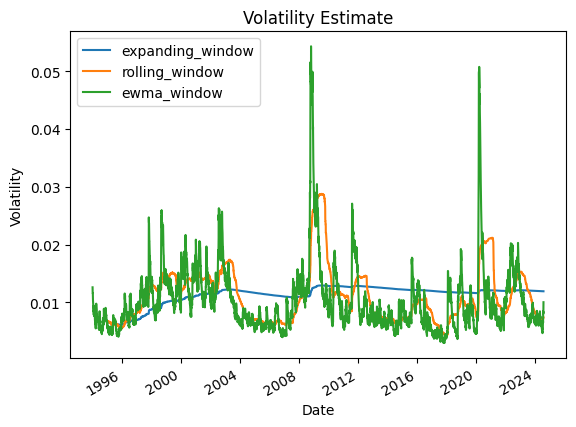

In [30]:
min_periods = 252

expending_window = np.sqrt((rets**2).expanding(min_periods).mean().shift())
rolling_window = np.sqrt((rets**2).rolling(min_periods).mean().shift())


# ewma

sigma0 = 0.2/(np.sqrt(min_periods))  # when is t0 here??
theta = 0.94

avail_date = rets.index  
ewma = pd.Series(index = rets.index, name = 'EWMA')
ewma.iloc[0] = sigma0

for i, idx in enumerate(avail_date[1:]):
    ewma.iloc[i+1] = np.sqrt(theta * (ewma.iloc[i]**2) + (1 - theta) * (rets.loc[idx] ** 2))

std = pd.DataFrame({'expanding_window': expending_window, 'rolling_window': rolling_window, 'ewma_window': ewma})
std.plot(title = 'Volatility Estimate',ylabel = 'Volatility', xlabel = 'Date')
plt.show()

In [36]:
var_temp = std.dropna()
frequency =  var_temp.apply(lambda x: rets.loc[var_temp.index] < x).mean()*100
frequency


expanding_window    87.479806
rolling_window      86.187399
ewma_window         83.992999
dtype: float64

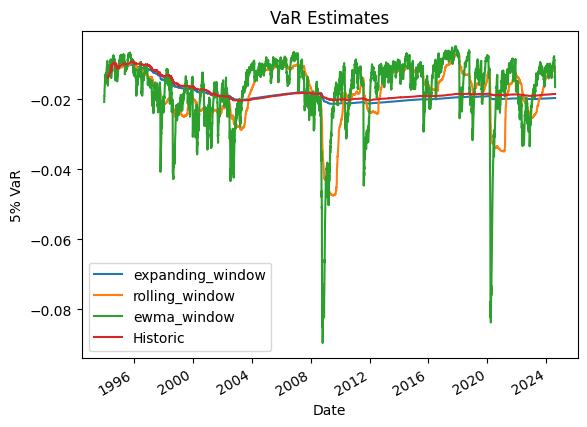

expanding_window    5.290792
rolling_window      5.290792
ewma_window         4.940765
Historic            5.654281
dtype: float64

In [35]:
# Introduce z 
VaR = -1.65 * std
VaR['Historic'] = historic_VaR

VaR.plot(title = 'VaR Estimates', ylabel = '5% VaR', xlabel = 'Date')
plt.show()


var_temp = VaR.dropna()
frequency =  var_temp.apply(lambda x: rets.loc[var_temp.index] < x).mean()*100
frequency

# cVaR

<Axes: title={'center': 'CVaR estimates'}, xlabel='Date', ylabel='5% CVaR'>

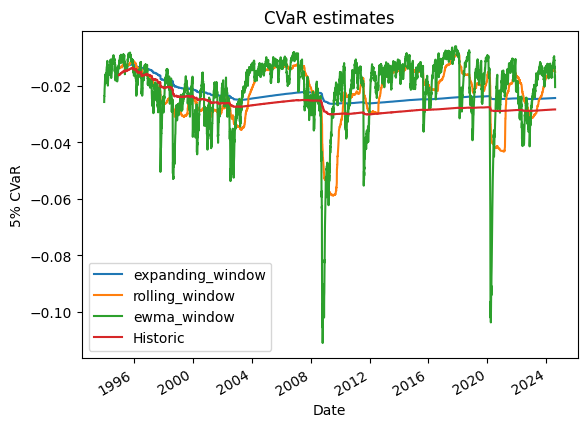

In [37]:
CVaR = -norm.pdf(1.65) / 0.05 * std
CVaR['Historic'] = rets.expanding(min_periods).apply(lambda x: x[x < x.quantile(var_quantile)].mean()).shift()
CVaR.plot(title = 'CVaR estimates', ylabel = '5% CVaR', xlabel = 'Date')